In [1]:
!pip install -q transformers
!pip install -q -U sentencepiece
!pip install pillow matplotlib torch torchvision torchaudio protobuf


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile
 
 
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")
 
 
    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)
 
 
    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])
 
 
        print("Done")
 
 
    except Exception as e:
        print("\nInvalid file.", e)
 
URL = r"https://www.dropbox.com/scl/fi/jz74me0vc118akmv5nuzy/images.zip?rlkey=54flzvhh9xxh45czb1c8n3fp3&dl=1"
asset_zip_path = os.path.join(os.getcwd(), "images.zip")
# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [4]:
def read_image(image_path):
    """
    :param image_path: String, path to the input image.
 
 
    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [5]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.
 
 
    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [6]:
def eval_new_data(data_path=None, num_samples=4, model=None):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_image(image_path)
        text = ocr(image, processor, model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()

In [7]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-small-printed'
).to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

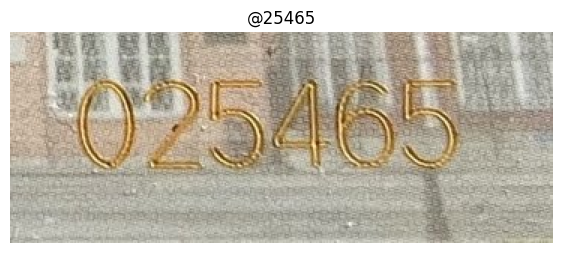

In [13]:
eval_new_data(
    data_path=os.path.join('..', 'data', '1111.jpg'),
    num_samples=2,
    model=model
)